<a href="https://www.kaggle.com/code/anderaraujo/laptop-price-prediction?scriptVersionId=105654123" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Laptop Price prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick

In [2]:
df = pd.read_csv('../input/laptop-price/laptop_price.csv',encoding = "ISO-8859-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


# Featuring Engineering

In [4]:
df.select_dtypes(exclude=['float64','int64']).describe()

,Company,Product,TypeName,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
count,1303,1303,1303,1303,1303,1303,1303,1303,1303,1303
unique,19,618,6,40,118,9,39,110,9,179
top,Dell,XPS 13,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.2kg
freq,297,30,727,507,190,619,412,281,1072,121


In [5]:
df = df.drop('Product', axis=1)
df

,laptop_ID,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1299,1317,Lenovo,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,1499.00
1300,1318,Lenovo,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00
1301,1319,HP,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.00


In [6]:
df['Weight'] = df['Weight'].str.extract(r'(\d.\d+|\d.\d|\d)')

In [7]:
df['Weight'] = df['Weight'].astype('float64')

In [8]:
df.Cpu.unique()

array(['Intel Core i5 2.3GHz', 'Intel Core i5 1.8GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Core i7 2.7GHz',
       'Intel Core i5 3.1GHz', 'AMD A9-Series 9420 3GHz',
       'Intel Core i7 2.2GHz', 'Intel Core i7 8550U 1.8GHz',
       'Intel Core i5 8250U 1.6GHz', 'Intel Core i3 6006U 2GHz',
       'Intel Core i7 2.8GHz', 'Intel Core M m3 1.2GHz',
       'Intel Core i7 7500U 2.7GHz', 'Intel Core i7 2.9GHz',
       'Intel Core i3 7100U 2.4GHz', 'Intel Atom x5-Z8350 1.44GHz',
       'Intel Core i5 7300HQ 2.5GHz', 'AMD E-Series E2-9000e 1.5GHz',
       'Intel Core i5 1.6GHz', 'Intel Core i7 8650U 1.9GHz',
       'Intel Atom x5-Z8300 1.44GHz', 'AMD E-Series E2-6110 1.5GHz',
       'AMD A6-Series 9220 2.5GHz',
       'Intel Celeron Dual Core N3350 1.1GHz',
       'Intel Core i3 7130U 2.7GHz', 'Intel Core i7 7700HQ 2.8GHz',
       'Intel Core i5 2.0GHz', 'AMD Ryzen 1700 3GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Atom x5-Z8550 1.44GHz',
       'Intel Celeron Du

In [9]:
df['Cpu_model'] = df['Cpu'].str.extract(r'(i\d|AMD|Samsung|Pentium|Celeron|Atom|Core M|Xeon)')

In [10]:
df.Cpu_model.isnull().sum()

0

In [11]:
df['Cpu_freq'] = df['Cpu'].str.extract(r'(\d+\.\d+GHz|\d+GHz)')

In [12]:
df['Cpu_freq'] = df['Cpu_freq'].str.replace('GHz','').astype('float64')

In [13]:
df['Cpu_freq'].isnull().sum()

0

In [14]:
df.ScreenResolution.unique()

array(['IPS Panel Retina Display 2560x1600', '1440x900',
       'Full HD 1920x1080', 'IPS Panel Retina Display 2880x1800',
       '1366x768', 'IPS Panel Full HD 1920x1080',
       'IPS Panel Retina Display 2304x1440',
       'IPS Panel Full HD / Touchscreen 1920x1080',
       'Full HD / Touchscreen 1920x1080',
       'Touchscreen / Quad HD+ 3200x1800',
       'IPS Panel Touchscreen 1920x1200', 'Touchscreen 2256x1504',
       'Quad HD+ / Touchscreen 3200x1800', 'IPS Panel 1366x768',
       'IPS Panel 4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Full HD 2160x1440',
       '4K Ultra HD / Touchscreen 3840x2160', 'Touchscreen 2560x1440',
       '1600x900', 'IPS Panel 4K Ultra HD 3840x2160',
       '4K Ultra HD 3840x2160', 'Touchscreen 1366x768',
       'IPS Panel Full HD 1366x768', 'IPS Panel 2560x1440',
       'IPS Panel Full HD 2560x1440',
       'IPS Panel Retina Display 2736x1824', 'Touchscreen 2400x1600',
       '2560x1440', 'IPS Panel Quad HD+ 2560x1440',
       'IPS Panel 

In [15]:
df['Resolution'] = df.ScreenResolution.str.extract(r'(\d+x\d+)')

In [16]:
df.Resolution.isnull().sum()

0

In [17]:
df.Memory.unique()

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '32GB Flash Storage', '128GB SSD +  1TB HDD',
       '256GB SSD +  256GB SSD', '64GB Flash Storage',
       '256GB SSD +  1TB HDD', '256GB SSD +  2TB HDD', '32GB SSD',
       '2TB HDD', '64GB SSD', '1.0TB Hybrid', '512GB SSD +  1TB HDD',
       '1TB SSD', '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

In [18]:
df['Memory_Size'] = df.Memory.str.extract(r'(\d+GB|\d+TB)')

In [19]:
df['Memory_Size'] = df.Memory_Size.str.extract(r'(\d+)').astype('int64')

In [20]:
df['Memory_Size'] = list((map((lambda x: x*1000 if x < 16 else x),df['Memory_Size'])))

In [21]:
df['Storage_type'] = df.Memory.str.extract(r'(.+[+].+|SSD|HDD|Flash Storage|Hybrid)')

In [22]:
df['Storage_type'].isnull().sum()

0

In [23]:
df.Gpu.unique()

array(['Intel Iris Plus Graphics 640', 'Intel HD Graphics 6000',
       'Intel HD Graphics 620', 'AMD Radeon Pro 455',
       'Intel Iris Plus Graphics 650', 'AMD Radeon R5',
       'Intel Iris Pro Graphics', 'Nvidia GeForce MX150',
       'Intel UHD Graphics 620', 'Intel HD Graphics 520',
       'AMD Radeon Pro 555', 'AMD Radeon R5 M430',
       'Intel HD Graphics 615', 'AMD Radeon Pro 560',
       'Nvidia GeForce 940MX', 'Intel HD Graphics 400',
       'Nvidia GeForce GTX 1050', 'AMD Radeon R2', 'AMD Radeon 530',
       'Nvidia GeForce 930MX', 'Intel HD Graphics',
       'Intel HD Graphics 500', 'Nvidia GeForce 930MX ',
       'Nvidia GeForce GTX 1060', 'Nvidia GeForce 150MX',
       'Intel Iris Graphics 540', 'AMD Radeon RX 580',
       'Nvidia GeForce 920MX', 'AMD Radeon R4 Graphics', 'AMD Radeon 520',
       'Nvidia GeForce GTX 1070', 'Nvidia GeForce GTX 1050 Ti',
       'Nvidia GeForce MX130', 'AMD R4 Graphics',
       'Nvidia GeForce GTX 940MX', 'AMD Radeon RX 560',
       'Nvid

In [24]:
df['Gpu_brand'] = df.Gpu.str.extract(r'(Nvidia|AMD|Intel)')

In [25]:
print([col for col in df.columns if df[col].isnull().sum() > 0])

['Gpu_brand']


In [26]:
df.Ram.unique()

array(['8GB', '16GB', '4GB', '2GB', '12GB', '6GB', '32GB', '24GB', '64GB'],
      dtype=object)

In [27]:
df['Ram'] = df.Ram.str.extract(r'(\d+)').astype('int64')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   int64  
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   float64
 11  Price_euros       1303 non-null   float64
 12  Cpu_model         1303 non-null   object 
 13  Cpu_freq          1303 non-null   float64
 14  Resolution        1303 non-null   object 
 15  Memory_Size       1303 non-null   int64  
 16  Storage_type      1303 non-null   object 


In [29]:
df1 = df.drop(['ScreenResolution','Cpu','Memory','Gpu','laptop_ID'], axis= 1)

In [30]:
df1.select_dtypes(exclude=['float64','int64']).describe()

,Company,TypeName,OpSys,Cpu_model,Resolution,Storage_type,Gpu_brand
count,1303,1303,1303,1303,1303,1303,1302
unique,19,6,9,10,15,19,3
top,Dell,Notebook,Windows 10,i7,1920x1080,SSD,Intel
freq,297,727,1072,527,841,637,722


In [31]:
df1.dropna(inplace=True)

In [32]:
df1.columns

Index(['Company', 'TypeName', 'Inches', 'Ram', 'OpSys', 'Weight',
       'Price_euros', 'Cpu_model', 'Cpu_freq', 'Resolution', 'Memory_Size',
       'Storage_type', 'Gpu_brand'],
      dtype='object')

# Exploratory data analisys

## Which company has higher sales?

<AxesSubplot:xlabel='Company', ylabel='Price_euros'>

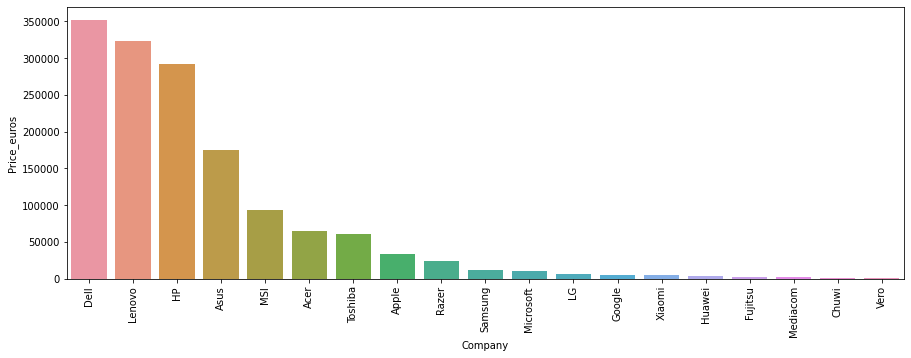

In [33]:
company_sales = df1.groupby('Company').sum().sort_values(by = 'Price_euros', ascending = False)
company_sales
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.barplot(data = company_sales, x= company_sales.index , y= 'Price_euros')

## How many Ram memory customers prefer buying a notebook?

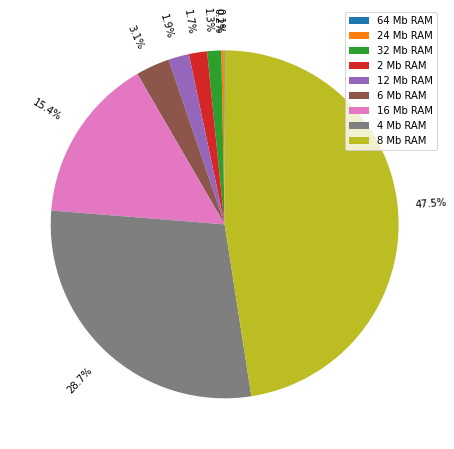

In [34]:
ram_sales = df1.groupby('Ram').count().sort_values(by = 'Company', ascending = True)
sales_pct = list(map(lambda x: (x/1302)*100, ram_sales.Company ))

fig4, ax4 = plt.subplots(figsize=(10,8))
ax4.pie(sales_pct, startangle= 90, labels = list(map(lambda x: f'{x:.1f}%',sales_pct)), rotatelabels= True)
ax4.legend(list(map(lambda x: f'{x} Mb RAM',ram_sales.index)), loc = 'best')
plt.show()


## Which OS is preferred ?

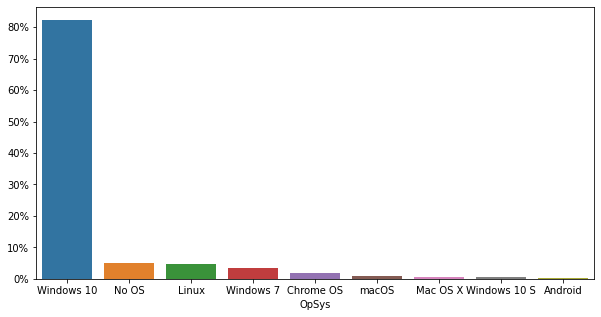

In [35]:
os_sales = df1.groupby('OpSys').count().sort_values(by = 'Company', ascending = False)
pct = list(map(lambda x: (x / 1302)*100, os_sales.Company))

fig, ax1 = plt.subplots(figsize=(10,5))
sns.barplot(data = os_sales, x= os_sales.index, y= pct)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

## Which Cpu frequency customers choose?

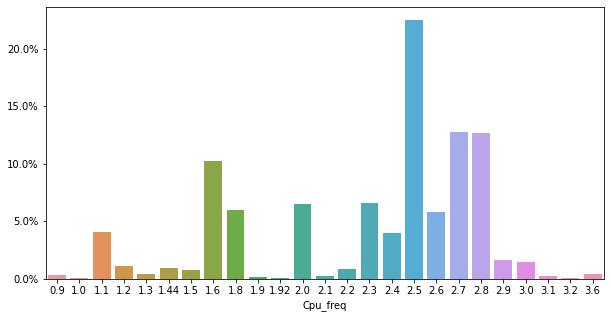

In [36]:
freq_sales = df1.groupby('Cpu_freq').count().sort_values(by = 'Company', ascending = False)

freq_pct = list(map(lambda x: (x/1302)*100, freq_sales.Company))

fig2, ax2 = plt.subplots(figsize = (10,5))
sns.barplot(x = freq_sales.index, y = freq_pct)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

## Which resolution do the customers prefer?

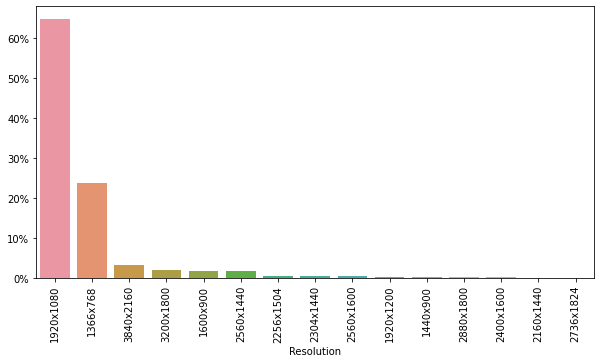

In [37]:
resolution_sales = df1.groupby(by = 'Resolution').count().sort_values(by = 'Company', ascending = False)

res_pct = list(map(lambda x: (x/1302)*100, resolution_sales.Company))

fig, ax3 = plt.subplots(figsize = (10,5))
sns.barplot(data = resolution_sales, x = resolution_sales.index, y = res_pct)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation = 90)
plt.show()

## Which variables are correlated to the price?

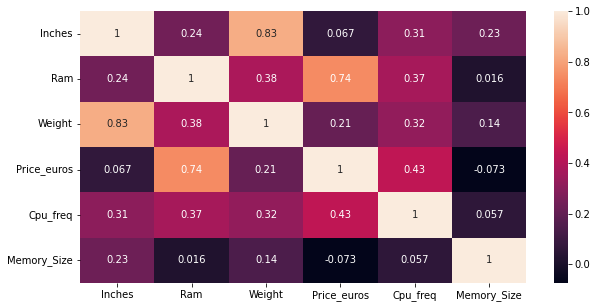

In [38]:
fig, ax = plt.subplots(figsize = (10,5))
sns.heatmap(df1.corr(), annot = True)
plt.show()

In [39]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Company       1302 non-null   object 
 1   TypeName      1302 non-null   object 
 2   Inches        1302 non-null   float64
 3   Ram           1302 non-null   int64  
 4   OpSys         1302 non-null   object 
 5   Weight        1302 non-null   float64
 6   Price_euros   1302 non-null   float64
 7   Cpu_model     1302 non-null   object 
 8   Cpu_freq      1302 non-null   float64
 9   Resolution    1302 non-null   object 
 10  Memory_Size   1302 non-null   int64  
 11  Storage_type  1302 non-null   object 
 12  Gpu_brand     1302 non-null   object 
dtypes: float64(4), int64(2), object(7)
memory usage: 142.4+ KB


# Preprocessing and Modeling

In [40]:
x = df1.drop('Price_euros', axis=1)
y = df1.Price_euros

In [41]:
x_train, x_val, y_train, y_val = train_test_split(x, y)

In [42]:
good_cat_cols = [col for col in x_train.columns if x_train[col].nunique() < 10 and x_train[col].dtype == 'object']
bad_cat_cols = [col for col in x_train.columns if x_train[col].nunique() > 10 and x_train[col].dtype == 'object']
num_cols = [col for col in x_train.columns if x_train[col].dtype != 'object']

In [43]:
cat_transf = OneHotEncoder(handle_unknown='ignore', sparse = False)
num_transf = MinMaxScaler(feature_range= (-1, 1))

In [44]:
preprocessor = ColumnTransformer(transformers = [('num', num_transf, num_cols),('cat', cat_transf, good_cat_cols)])

In [45]:
num_cols

['Inches', 'Ram', 'Weight', 'Cpu_freq', 'Memory_Size']

## XGboost model

In [46]:
model = XGBRegressor(n_estimators = 10)

In [47]:
clf = Pipeline(steps= [('preprocessor',preprocessor),('model', model)])

In [48]:
clf.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  ['Inches', 'Ram', 'Weight',
                                                   'Cpu_freq', 'Memory_Size']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['TypeName', 'OpSys',
                                                   'Cpu_model',
                                                   'Gpu_brand'])])),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_...
  

In [49]:
preds = clf.predict(x_val)

In [50]:
xgb_r2 = r2_score(y_val, preds)

In [51]:
mean_absolute_error(y_val, preds)

203.70374501421406

## Random Forest model

In [52]:
model1 = RandomForestRegressor(n_estimators = 10)

In [53]:
clf2 = Pipeline(steps=[('preprocessor',preprocessor),('model1', model1)])

In [54]:
clf2.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  ['Inches', 'Ram', 'Weight',
                                                   'Cpu_freq', 'Memory_Size']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['TypeName', 'OpSys',
                                                   'Cpu_model',
                                                   'Gpu_brand'])])),
                ('model1', RandomForestRegressor(n_estimators=10))])

In [55]:
preds2 = clf2.predict(x_val)

In [56]:
rf_r2 = r2_score(y_val, preds2)

In [57]:
print(f'R2 for Random forest regression = {rf_r2:.2f}\nR2 for XGBoost Regressor = {xgb_r2:.2f}')

R2 for Random forest regression = 0.68
R2 for XGBoost Regressor = 0.76


In [58]:
cat_features = preprocessor.transformers_[1][1].get_feature_names().tolist()

In [59]:
feature_names = num_cols

In [60]:
feature_names.extend(cat_features)

## What is the most important feature for price?

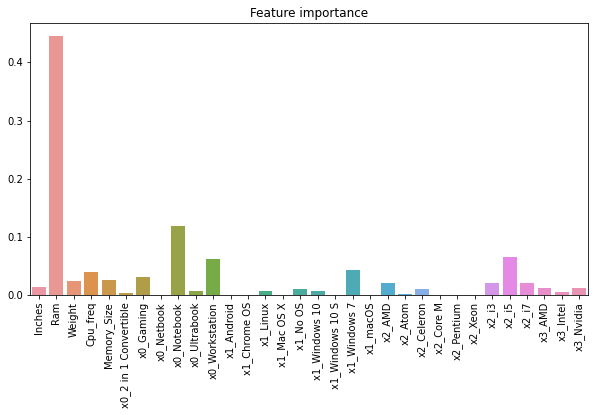

In [61]:
plt.figure(figsize = (10,5))
sns.barplot(x = feature_names ,y= model.feature_importances_)
plt.xticks(rotation = 90)
plt.title('Feature importance')
plt.show()